In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras.applications
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
img_width, img_height = 480, 480
batch = 32
num_classes = 6
input_shape = (img_width, img_height, 3)

train_dir = "HiRISE/fold-1/2345-as-training"
test_dir = "HiRISE/fold-1/1-as-test"

In [4]:
from sklearn.utils import compute_class_weight

# Data generators
trdata = ImageDataGenerator(zoom_range=0.2, rotation_range=0.5, horizontal_flip=True,
                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='nearest')
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=True, class_mode='categorical')

class_weights = compute_class_weight('balanced', classes=np.unique(traindata.classes), y=traindata.classes)

# Get the class indices and the number of images in each class
class_indices = traindata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in traindata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=False, class_mode='categorical')
# Get the class indices and the number of images in each class
class_indices = testdata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in testdata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

Found 3053 images belonging to 6 classes.
Class: bright_dune, Number of images: 124
Class: crater, Number of images: 295
Class: dark_dune, Number of images: 326
Class: edge, Number of images: 665
Class: other, Number of images: 1614
Class: streak, Number of images: 29
Found 767 images belonging to 6 classes.
Class: bright_dune, Number of images: 32
Class: crater, Number of images: 74
Class: dark_dune, Number of images: 82
Class: edge, Number of images: 167
Class: other, Number of images: 404
Class: streak, Number of images: 8


In [5]:
pre_trained_model = tf.keras.applications.EfficientNetV2M(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
# pre_trained_model.summary()

In [6]:
# Add custom layers on top of the pre-trained model
x = pre_trained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:

# Print model summary to verify the architecture
# model.summary()

In [8]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("EfficientNetV2M", monitor="val_acc",verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',save_freq=1)
early = EarlyStopping(monitor="val_acc",min_delta=0, patience=20, verbose=1, mode='auto')
epochs = 75
history = model.fit(traindata, validation_data=testdata, epochs=epochs, verbose=1)

Epoch 1/75
96/96 [==============================] - 75s 643ms/step - loss: 0.7715 - accuracy: 0.7294 - val_loss: 0.4766 - val_accuracy: 0.8566
Epoch 2/75
96/96 [==============================] - 57s 594ms/step - loss: 0.4191 - accuracy: 0.8611 - val_loss: 0.3672 - val_accuracy: 0.8866
Epoch 3/75
96/96 [==============================] - 58s 596ms/step - loss: 0.3486 - accuracy: 0.8791 - val_loss: 0.3320 - val_accuracy: 0.8944
Epoch 4/75
96/96 [==============================] - 58s 595ms/step - loss: 0.3222 - accuracy: 0.8870 - val_loss: 0.3198 - val_accuracy: 0.9061
Epoch 5/75
96/96 [==============================] - 58s 595ms/step - loss: 0.2861 - accuracy: 0.8972 - val_loss: 0.2922 - val_accuracy: 0.9074
Epoch 6/75
96/96 [==============================] - 58s 595ms/step - loss: 0.2747 - accuracy: 0.8981 - val_loss: 0.2896 - val_accuracy: 0.8996
Epoch 7/75
96/96 [==============================] - 57s 594ms/step - loss: 0.2620 - accuracy: 0.9001 - val_loss: 0.2818 - val_accuracy: 0.9048

In [10]:
model.save("EfficientNet-HiRISEF1.keras")

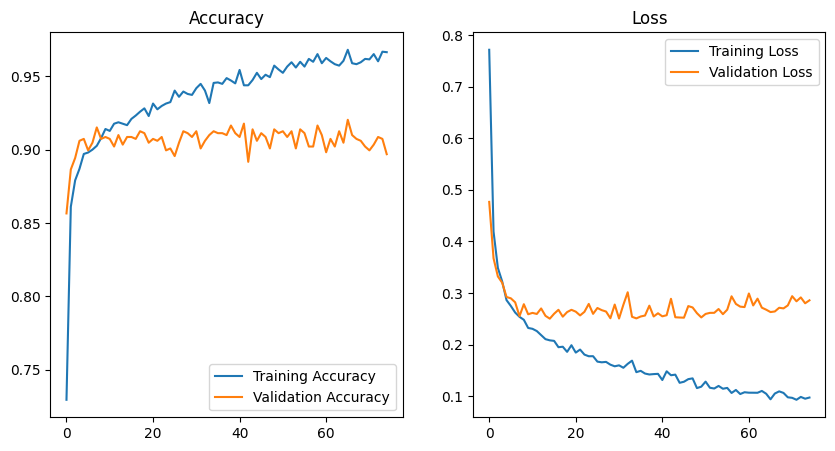

In [11]:
import matplotlib.pyplot as plt

#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [12]:
# evaluate the accuracy
score = model.evaluate(testdata, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

Validation Loss: 0.285718709230423
Validation Accuracy: 0.897001326084137
Min Validation Loss: 0.2501390278339386
Max Validation Accuracy: 0.920469343662262


In [13]:
# generate the confusion matrix

# predict on the test dataset
validation_predictions = model.predict(testdata)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

print(predicted_labels)
print(testdata.classes)
print(validation_predictions)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(testdata.classes, predicted_labels)
print(confusion)

24/24 [==============================] - 13s 463ms/step
[0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 4 4 1 1 1 1
 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 1 4
 0 1 1 4 1 1 1 1 4 1 1 1 1 1 4 4 4 1 4 1 1 1 1 1 4 4 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 4 4 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 4 3 4 3 3 4 3 3 3 2 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3
 3 3 3 3 3 3 4 4 3 3 3 3 4 3 2 4 3 3 3 4 3 3 3 4 3 4 4 3 3 3 3 3 4 3 3 4 3
 3 3 3 4 3 3 4 3 4 3 4 3 3 4 4 4 4 3 3 3 3 3 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1
 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 1 4 4
 4 4 4 4 4 4 4 4 3 4 4 4 1 3 4 4 4 4 4 4 4 4

['bright_dune', 'crater', 'dark_dune', 'edge', 'other', 'streak']


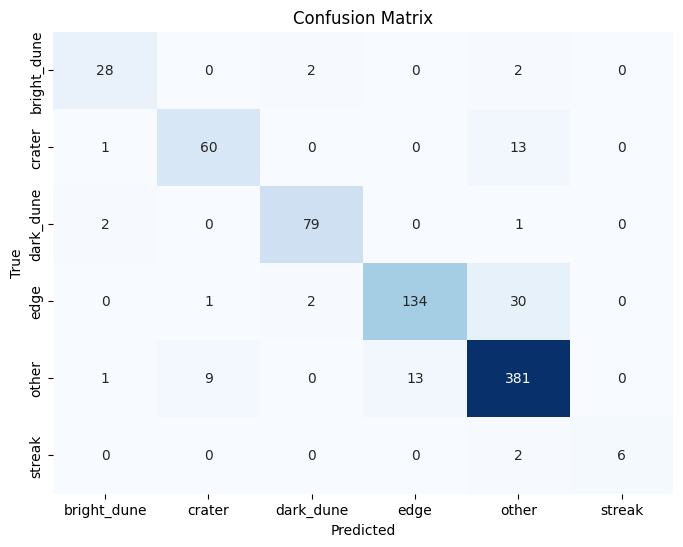

In [14]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(traindata.class_indices.keys())
print(class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(testdata.classes, predicted_labels, average=None)
recall_per_class = recall_score(testdata.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(testdata.classes, predicted_labels, average='weighted')
overall_recall = recall_score(testdata.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(testdata.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)

Class: bright_dune
Precision: 0.88
Recall: 0.88
------------
Class: crater
Precision: 0.86
Recall: 0.81
------------
Class: dark_dune
Precision: 0.95
Recall: 0.96
------------
Class: edge
Precision: 0.91
Recall: 0.80
------------
Class: other
Precision: 0.89
Recall: 0.94
------------
Class: streak
Precision: 1.00
Recall: 0.75
------------
Overall Precision: 0.8976600515174256
Overall Recall: 0.8970013037809648
Classification Report:
               precision    recall  f1-score   support

 bright_dune       0.88      0.88      0.88        32
      crater       0.86      0.81      0.83        74
   dark_dune       0.95      0.96      0.96        82
        edge       0.91      0.80      0.85       167
       other       0.89      0.94      0.91       404
      streak       1.00      0.75      0.86         8

    accuracy                           0.90       767
   macro avg       0.91      0.86      0.88       767
weighted avg       0.90      0.90      0.90       767



## Fold 2

In [16]:
train_dir = "HiRISE/fold-2/1345-as-training"
test_dir = "HiRISE/fold-2/2-as-test"

# Data generators
trdata = ImageDataGenerator(zoom_range=0.2, rotation_range=0.5, horizontal_flip=True,
                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='nearest')
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=True, class_mode='categorical')

class_weights = compute_class_weight('balanced', classes=np.unique(traindata.classes), y=traindata.classes)

# Get the class indices and the number of images in each class
class_indices = traindata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in traindata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=False, class_mode='categorical')
# Get the class indices and the number of images in each class
class_indices = testdata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in testdata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

pre_trained_model = tf.keras.applications.EfficientNetV2M(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = pre_trained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("EfficientNetV2M", monitor="val_acc",verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',save_freq=1)
early = EarlyStopping(monitor="val_acc",min_delta=0, patience=20, verbose=1, mode='auto')
epochs = 75
history = model.fit(traindata, validation_data=testdata, epochs=epochs, verbose=1)
model.save("EfficientNet-HiRISEF2")

Found 2646 images belonging to 6 classes.
Class: bright_dune, Number of images: 125
Class: crater, Number of images: 295
Class: dark_dune, Number of images: 326
Class: edge, Number of images: 665
Class: other, Number of images: 1206
Class: streak, Number of images: 29
Found 766 images belonging to 6 classes.
Class: bright_dune, Number of images: 31
Class: crater, Number of images: 74
Class: dark_dune, Number of images: 82
Class: edge, Number of images: 167
Class: other, Number of images: 404
Class: streak, Number of images: 8
Epoch 1/75
83/83 [==============================] - 75s 822ms/step - loss: 0.8286 - accuracy: 0.7196 - val_loss: 0.5056 - val_accuracy: 0.8629
Epoch 2/75
83/83 [==============================] - 51s 605ms/step - loss: 0.4538 - accuracy: 0.8485 - val_loss: 0.3762 - val_accuracy: 0.8890
Epoch 3/75
83/83 [==============================] - 51s 606ms/step - loss: 0.3706 - accuracy: 0.8685 - val_loss: 0.3375 - val_accuracy: 0.8969
Epoch 4/75
83/83 [=====================

INFO:tensorflow:Assets written to: EfficientNet-HiRISEF2\assets


INFO:tensorflow:Assets written to: EfficientNet-HiRISEF2\assets


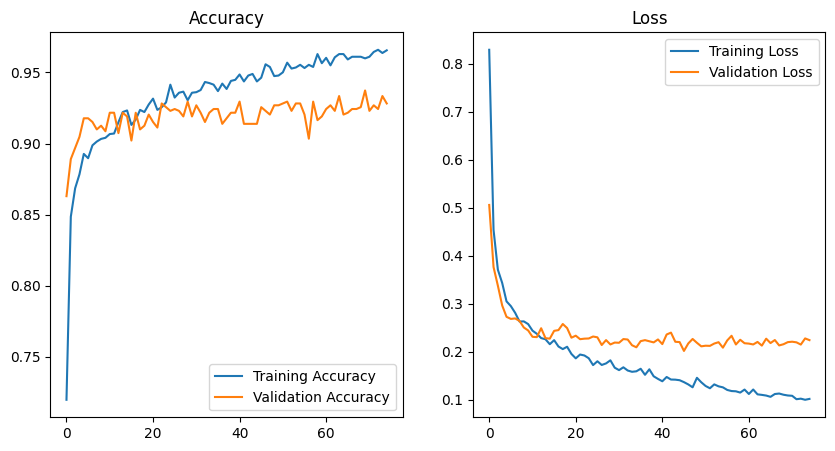

Validation Loss: 0.2240847796201706
Validation Accuracy: 0.9281984567642212
Min Validation Loss: 0.201585054397583
Max Validation Accuracy: 0.937336802482605
24/24 [==============================] - 12s 422ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 4 0 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1
 1 1 4 1 1 1 1 1 4 1 1 1 1 1 1 3 4 1 1 1 3 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3
 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 3 3 3 3 3 3 2 3 3 3 4 3 3 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4

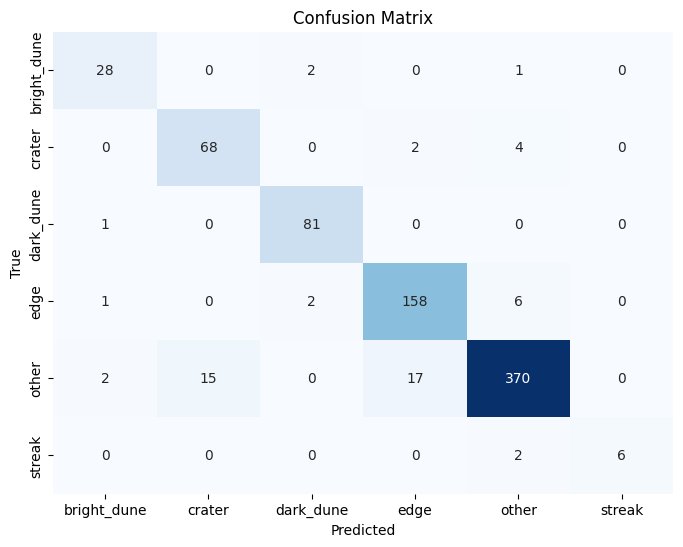

Class: bright_dune
Precision: 0.88
Recall: 0.90
------------
Class: crater
Precision: 0.82
Recall: 0.92
------------
Class: dark_dune
Precision: 0.95
Recall: 0.99
------------
Class: edge
Precision: 0.89
Recall: 0.95
------------
Class: other
Precision: 0.97
Recall: 0.92
------------
Class: streak
Precision: 1.00
Recall: 0.75
------------
Overall Precision: 0.9311401241366668
Overall Recall: 0.9281984334203656
Classification Report:
               precision    recall  f1-score   support

 bright_dune       0.88      0.90      0.89        31
      crater       0.82      0.92      0.87        74
   dark_dune       0.95      0.99      0.97        82
        edge       0.89      0.95      0.92       167
       other       0.97      0.92      0.94       404
      streak       1.00      0.75      0.86         8

    accuracy                           0.93       766
   macro avg       0.92      0.90      0.91       766
weighted avg       0.93      0.93      0.93       766



In [17]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# evaluate the accuracy
score = model.evaluate(testdata, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

# generate the confusion matrix

# predict on the test dataset
validation_predictions = model.predict(testdata)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

print(predicted_labels)
print(testdata.classes)
print(validation_predictions)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(testdata.classes, predicted_labels)
print(confusion)

# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(traindata.class_indices.keys())
print(class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(testdata.classes, predicted_labels, average=None)
recall_per_class = recall_score(testdata.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(testdata.classes, predicted_labels, average='weighted')
overall_recall = recall_score(testdata.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(testdata.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)

## Fold 3

In [18]:
train_dir = "HiRISE/fold-3/1245-as-training"
test_dir = "HiRISE/fold-3/3-as-test"

# Data generators
trdata = ImageDataGenerator(zoom_range=0.2, rotation_range=0.5, horizontal_flip=True,
                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='nearest')
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=True, class_mode='categorical')

class_weights = compute_class_weight('balanced', classes=np.unique(traindata.classes), y=traindata.classes)

# Get the class indices and the number of images in each class
class_indices = traindata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in traindata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=False, class_mode='categorical')
# Get the class indices and the number of images in each class
class_indices = testdata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in testdata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

pre_trained_model = tf.keras.applications.EfficientNetV2M(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = pre_trained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("EfficientNetV2M", monitor="val_acc",verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',save_freq=1)
early = EarlyStopping(monitor="val_acc",min_delta=0, patience=20, verbose=1, mode='auto')
epochs = 75
history = model.fit(traindata, validation_data=testdata, epochs=epochs, verbose=1)
model.save("EfficientNet-HiRISEF3")

Found 2639 images belonging to 6 classes.
Class: bright_dune, Number of images: 125
Class: crater, Number of images: 295
Class: dark_dune, Number of images: 326
Class: edge, Number of images: 666
Class: other, Number of images: 1197
Class: streak, Number of images: 30
Found 764 images belonging to 6 classes.
Class: bright_dune, Number of images: 31
Class: crater, Number of images: 74
Class: dark_dune, Number of images: 82
Class: edge, Number of images: 166
Class: other, Number of images: 404
Class: streak, Number of images: 7
Epoch 1/75
83/83 [==============================] - 77s 848ms/step - loss: 0.8325 - accuracy: 0.7260 - val_loss: 0.5380 - val_accuracy: 0.8390
Epoch 2/75
83/83 [==============================] - 52s 621ms/step - loss: 0.4490 - accuracy: 0.8556 - val_loss: 0.4232 - val_accuracy: 0.8534
Epoch 3/75
83/83 [==============================] - 52s 623ms/step - loss: 0.3592 - accuracy: 0.8814 - val_loss: 0.3825 - val_accuracy: 0.8678
Epoch 4/75
83/83 [=====================

INFO:tensorflow:Assets written to: EfficientNet-HiRISEF3\assets


INFO:tensorflow:Assets written to: EfficientNet-HiRISEF3\assets


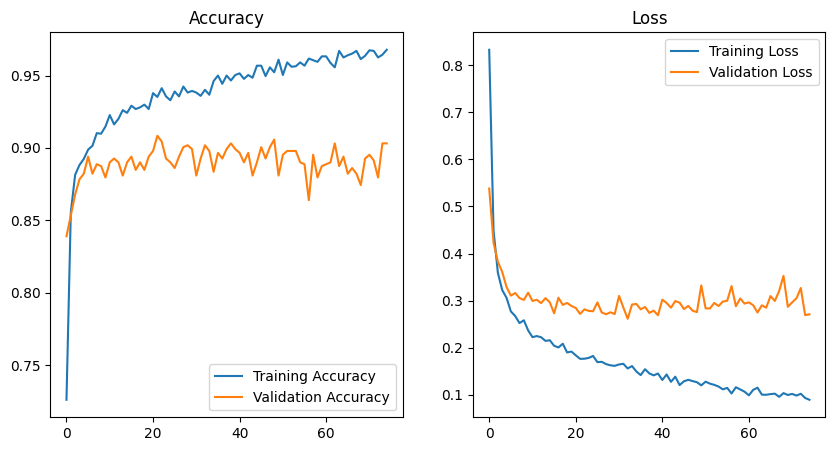

Validation Loss: 0.270911306142807
Validation Accuracy: 0.9031413793563843
Min Validation Loss: 0.2614975869655609
Max Validation Accuracy: 0.9083769917488098
24/24 [==============================] - 12s 420ms/step
[0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 0 0 0 0 0 0 0 2 0 0 0 4 0 0 0 2 4 1 1 1 1 1
 1 1 1 1 1 4 1 1 1 1 1 4 1 4 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3
 3 3 3 3 0 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 0
 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 4 3 3 3 3 3 3 3 2 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 4 3 3 4 1 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 3 4 4 4 3 4 4 4 4 

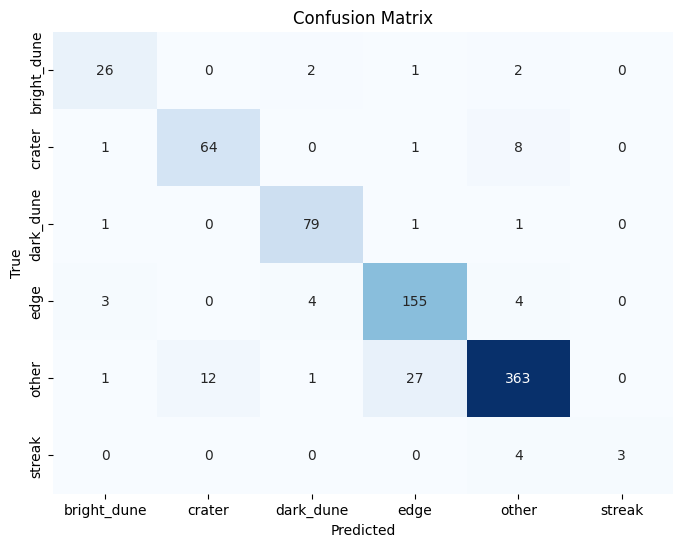

Class: bright_dune
Precision: 0.81
Recall: 0.84
------------
Class: crater
Precision: 0.84
Recall: 0.86
------------
Class: dark_dune
Precision: 0.92
Recall: 0.96
------------
Class: edge
Precision: 0.84
Recall: 0.93
------------
Class: other
Precision: 0.95
Recall: 0.90
------------
Class: streak
Precision: 1.00
Recall: 0.43
------------
Overall Precision: 0.9068268470057825
Overall Recall: 0.9031413612565445
Classification Report:
               precision    recall  f1-score   support

 bright_dune       0.81      0.84      0.83        31
      crater       0.84      0.86      0.85        74
   dark_dune       0.92      0.96      0.94        82
        edge       0.84      0.93      0.88       166
       other       0.95      0.90      0.92       404
      streak       1.00      0.43      0.60         7

    accuracy                           0.90       764
   macro avg       0.89      0.82      0.84       764
weighted avg       0.91      0.90      0.90       764



In [19]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# evaluate the accuracy
score = model.evaluate(testdata, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

# generate the confusion matrix

# predict on the test dataset
validation_predictions = model.predict(testdata)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

print(predicted_labels)
print(testdata.classes)
print(validation_predictions)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(testdata.classes, predicted_labels)
print(confusion)

# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(traindata.class_indices.keys())
print(class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(testdata.classes, predicted_labels, average=None)
recall_per_class = recall_score(testdata.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(testdata.classes, predicted_labels, average='weighted')
overall_recall = recall_score(testdata.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(testdata.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)

## Fold 4

In [20]:
train_dir = "HiRISE/fold-4/1235-as-training"
test_dir = "HiRISE/fold-4/4-as-test"

# Data generators
trdata = ImageDataGenerator(zoom_range=0.2, rotation_range=0.5, horizontal_flip=True,
                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='nearest')
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=True, class_mode='categorical')

class_weights = compute_class_weight('balanced', classes=np.unique(traindata.classes), y=traindata.classes)

# Get the class indices and the number of images in each class
class_indices = traindata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in traindata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=False, class_mode='categorical')
# Get the class indices and the number of images in each class
class_indices = testdata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in testdata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

pre_trained_model = tf.keras.applications.EfficientNetV2M(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = pre_trained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("EfficientNetV2M", monitor="val_acc",verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',save_freq=1)
early = EarlyStopping(monitor="val_acc",min_delta=0, patience=20, verbose=1, mode='auto')
epochs = 75
history = model.fit(traindata, validation_data=testdata, epochs=epochs, verbose=1)
model.save("EfficientNet-HiRISEF4")

Found 2761 images belonging to 6 classes.
Class: bright_dune, Number of images: 125
Class: crater, Number of images: 295
Class: dark_dune, Number of images: 327
Class: edge, Number of images: 666
Class: other, Number of images: 1318
Class: streak, Number of images: 30
Found 762 images belonging to 6 classes.
Class: bright_dune, Number of images: 31
Class: crater, Number of images: 74
Class: dark_dune, Number of images: 81
Class: edge, Number of images: 166
Class: other, Number of images: 403
Class: streak, Number of images: 7
Epoch 1/75
87/87 [==============================] - 82s 860ms/step - loss: 0.7745 - accuracy: 0.7439 - val_loss: 0.5402 - val_accuracy: 0.8294
Epoch 2/75
87/87 [==============================] - 57s 652ms/step - loss: 0.4354 - accuracy: 0.8573 - val_loss: 0.4452 - val_accuracy: 0.8530
Epoch 3/75
87/87 [==============================] - 57s 650ms/step - loss: 0.3560 - accuracy: 0.8819 - val_loss: 0.3853 - val_accuracy: 0.8661
Epoch 4/75
87/87 [=====================

INFO:tensorflow:Assets written to: EfficientNet-HiRISEF4\assets


INFO:tensorflow:Assets written to: EfficientNet-HiRISEF4\assets


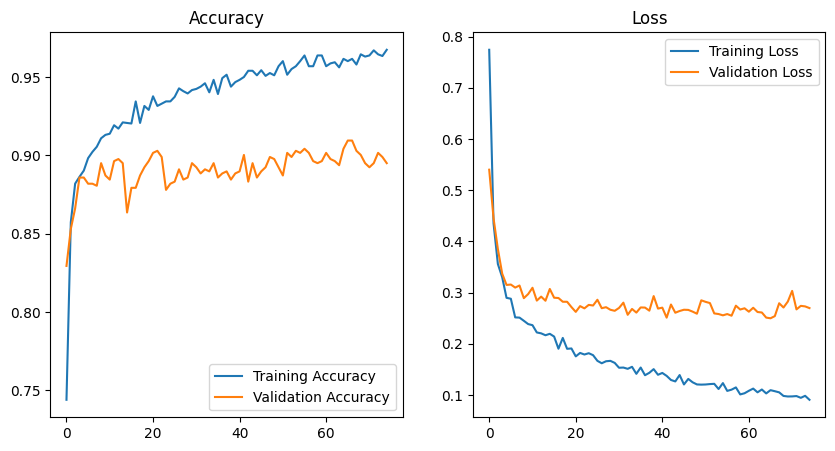

Validation Loss: 0.2698688805103302
Validation Accuracy: 0.8950130939483643
Min Validation Loss: 0.24993878602981567
Max Validation Accuracy: 0.9094488024711609
24/24 [==============================] - 12s 454ms/step
[0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 3 4 4 0 0 2 1 1 3 1 1 1
 1 1 1 1 1 1 4 4 1 1 4 1 4 1 1 4 1 1 4 4 1 1 1 1 4 4 4 1 1 1 1 1 1 1 1 1 4
 1 1 1 1 1 4 1 4 1 1 1 1 1 4 1 1 4 1 1 1 4 1 1 4 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 4 3 3 3 3 3 3 3 3
 1 3 3 3 3 3 3 3 3 0 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 1 3 3 3 3 3 3 3 2 3 3 3 4 3 3 3 3 3 3 4 4 3 3 4 3 3 3 3 3 3 4 3 3
 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 

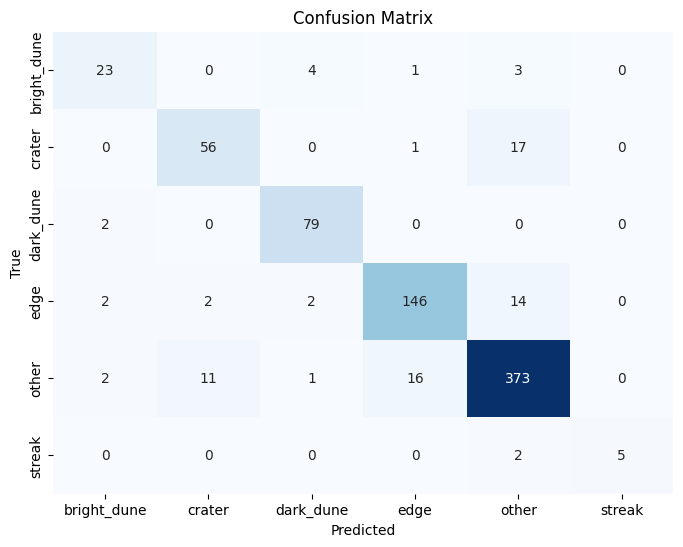

Class: bright_dune
Precision: 0.79
Recall: 0.74
------------
Class: crater
Precision: 0.81
Recall: 0.76
------------
Class: dark_dune
Precision: 0.92
Recall: 0.98
------------
Class: edge
Precision: 0.89
Recall: 0.88
------------
Class: other
Precision: 0.91
Recall: 0.93
------------
Class: streak
Precision: 1.00
Recall: 0.71
------------
Overall Precision: 0.8941729131489786
Overall Recall: 0.89501312335958
Classification Report:
               precision    recall  f1-score   support

 bright_dune       0.79      0.74      0.77        31
      crater       0.81      0.76      0.78        74
   dark_dune       0.92      0.98      0.95        81
        edge       0.89      0.88      0.88       166
       other       0.91      0.93      0.92       403
      streak       1.00      0.71      0.83         7

    accuracy                           0.90       762
   macro avg       0.89      0.83      0.86       762
weighted avg       0.89      0.90      0.89       762



In [21]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# evaluate the accuracy
score = model.evaluate(testdata, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

# generate the confusion matrix

# predict on the test dataset
validation_predictions = model.predict(testdata)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

print(predicted_labels)
print(testdata.classes)
print(validation_predictions)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(testdata.classes, predicted_labels)
print(confusion)

# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(traindata.class_indices.keys())
print(class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(testdata.classes, predicted_labels, average=None)
recall_per_class = recall_score(testdata.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(testdata.classes, predicted_labels, average='weighted')
overall_recall = recall_score(testdata.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(testdata.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)

## Fold 5

In [22]:
train_dir = "HiRISE/fold-5/1234-as-training"
test_dir = "HiRISE/fold-5/5-as-test"

# Data generators
trdata = ImageDataGenerator(zoom_range=0.2, rotation_range=0.5, horizontal_flip=True,
                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='nearest')
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=True, class_mode='categorical')

class_weights = compute_class_weight('balanced', classes=np.unique(traindata.classes), y=traindata.classes)

# Get the class indices and the number of images in each class
class_indices = traindata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in traindata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(img_width, img_height), batch_size=batch, shuffle=False, class_mode='categorical')
# Get the class indices and the number of images in each class
class_indices = testdata.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in testdata.classes:
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

pre_trained_model = tf.keras.applications.EfficientNetV2M(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = pre_trained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("EfficientNetV2M", monitor="val_acc",verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',save_freq=1)
early = EarlyStopping(monitor="val_acc",min_delta=0, patience=20, verbose=1, mode='auto')
epochs = 75
history = model.fit(traindata, validation_data=testdata, epochs=epochs, verbose=1)
model.save("EfficientNet-HiRISEF5`")

Found 2569 images belonging to 6 classes.
Class: bright_dune, Number of images: 125
Class: crater, Number of images: 296
Class: dark_dune, Number of images: 327
Class: edge, Number of images: 666
Class: other, Number of images: 1125
Class: streak, Number of images: 30
Found 761 images belonging to 6 classes.
Class: bright_dune, Number of images: 31
Class: crater, Number of images: 73
Class: dark_dune, Number of images: 81
Class: edge, Number of images: 166
Class: other, Number of images: 403
Class: streak, Number of images: 7
Epoch 1/75
81/81 [==============================] - 81s 892ms/step - loss: 0.8282 - accuracy: 0.7131 - val_loss: 0.5429 - val_accuracy: 0.8371
Epoch 2/75
81/81 [==============================] - 55s 679ms/step - loss: 0.4442 - accuracy: 0.8583 - val_loss: 0.4576 - val_accuracy: 0.8502
Epoch 3/75
81/81 [==============================] - 55s 679ms/step - loss: 0.3541 - accuracy: 0.8821 - val_loss: 0.3866 - val_accuracy: 0.8791
Epoch 4/75
81/81 [=====================

INFO:tensorflow:Assets written to: EfficientNet-HiRISEF5`\assets


INFO:tensorflow:Assets written to: EfficientNet-HiRISEF5`\assets


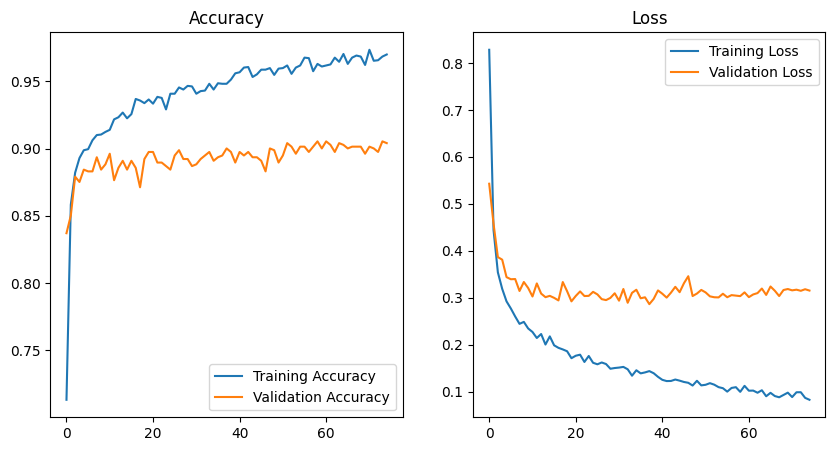

Validation Loss: 0.3153301477432251
Validation Accuracy: 0.9040735960006714
Min Validation Loss: 0.28640636801719666
Max Validation Accuracy: 0.9053876399993896
24/24 [==============================] - 12s 420ms/step
[4 0 0 0 0 0 3 0 0 0 0 0 4 0 0 0 0 0 0 0 0 2 0 2 0 3 0 0 0 0 2 1 1 1 1 1 1
 1 1 1 4 1 1 1 4 1 1 1 4 1 1 4 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4
 1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 4 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 3 4 3 3 3 3 3 2 3 3 3 4 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3
 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 3 4 4 4 4 4 3 4 4 4 4 4 4 

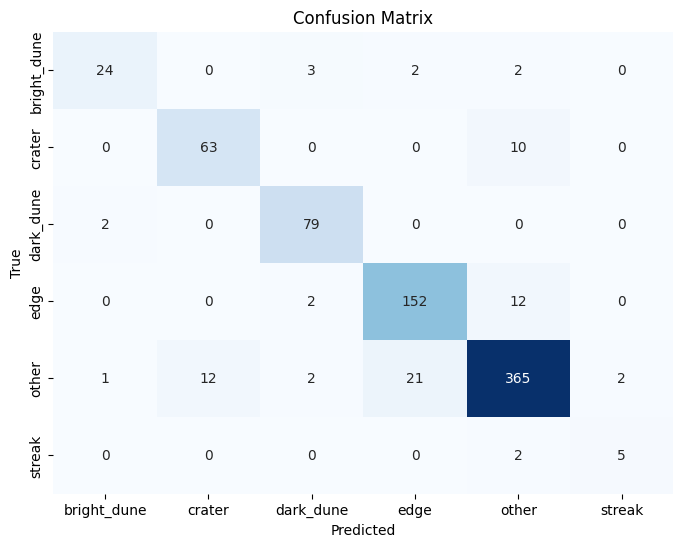

Class: bright_dune
Precision: 0.89
Recall: 0.77
------------
Class: crater
Precision: 0.84
Recall: 0.86
------------
Class: dark_dune
Precision: 0.92
Recall: 0.98
------------
Class: edge
Precision: 0.87
Recall: 0.92
------------
Class: other
Precision: 0.93
Recall: 0.91
------------
Class: streak
Precision: 0.71
Recall: 0.71
------------
Overall Precision: 0.9049506379479688
Overall Recall: 0.9040735873850198
Classification Report:
               precision    recall  f1-score   support

 bright_dune       0.89      0.77      0.83        31
      crater       0.84      0.86      0.85        73
   dark_dune       0.92      0.98      0.95        81
        edge       0.87      0.92      0.89       166
       other       0.93      0.91      0.92       403
      streak       0.71      0.71      0.71         7

    accuracy                           0.90       761
   macro avg       0.86      0.86      0.86       761
weighted avg       0.90      0.90      0.90       761



In [23]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# evaluate the accuracy
score = model.evaluate(testdata, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

# generate the confusion matrix

# predict on the test dataset
validation_predictions = model.predict(testdata)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

print(predicted_labels)
print(testdata.classes)
print(validation_predictions)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(testdata.classes, predicted_labels)
print(confusion)

# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(traindata.class_indices.keys())
print(class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(testdata.classes, predicted_labels, average=None)
recall_per_class = recall_score(testdata.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(testdata.classes, predicted_labels, average='weighted')
overall_recall = recall_score(testdata.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(testdata.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)